In [ ]:
import torch
from IPython.display import Image
import pandas as pd
import random
import os
from shutil import copyfile
from google.colab import drive

drive.mount('/content/drive')
dir_ = '/content/drive/MyDrive/Mila/ift6759_trees'

%cd drive/MyDrive/Mila/ift6759_trees/
# !git clone https://github.com/ultralytics/yolov5 -q  # clone repo
!pip install -r yolov5/requirements.txt -q # install dependencies
%cd yolov5

### DO NOT RE-RUN ALL THE TIME

#### Send data to yolov5 folder

In [ ]:
# copy images + labels to the training location

def send_data_to_YOLO(df,dir_input, path):

  w = 200
  h = 200

  for id in list(set(df.rsFile)):
      image_data = df[df['rsFile'] == id]
    
      minx_pixel = image_data['minx_pixel']
      miny_pixel = image_data['miny_pixel']
      maxx_pixel = image_data['maxx_pixel']
      maxy_pixel = image_data['maxy_pixel']


      filename = os.path.splitext(image_data.iloc[0]['rsFile'])[0]
      img_path = os.path.join(dir_input, filename + '.jpg')
    
      
      
      with open('data/labels/{}/'.format(path) + str(filename) + '.txt', 'w+') as file:
          for i in range(len(minx_pixel)):
              xc, yc = minx_pixel.iloc[i],miny_pixel.iloc[i]
              
              x_center_n = (maxx_pixel.iloc[i] + minx_pixel.iloc[i]) / 2 / 200
              y_center_n = (maxy_pixel.iloc[i] + miny_pixel.iloc[i]) / 2 /200
              width_n = (maxx_pixel.iloc[i] - minx_pixel.iloc[i]) /200
              height_n = (miny_pixel.iloc[i] - maxy_pixel.iloc[i]) /200
              line = ' '.join(('0', str(x_center_n), str(y_center_n), str(width_n), str(height_n))) + '\n'
              file.write(line)
                        
      copyfile(img_path, 'data/images/{}/'.format(path) + filename +'.jpg')



In [ ]:
path = 'train'
train_df = pd.read_csv(os.path.join(dir_,'data/interim/ITC/train_pixel_v2.csv'))
dir_input = os.path.join(dir_,f'data/processed/{path}/RGH-jpg')
send_data_to_YOLO(train_df,dir_input,path)

In [ ]:
path = 'valid'
val_df = pd.read_csv(os.path.join(dir_,'data/interim/ITC/val_pixel_v2.csv'))
dir_input = os.path.join(dir_,f'data/processed/val/RGH-jpg')
send_data_to_YOLO(val_df,dir_input,path)

In [ ]:
path = 'test'
test_df = pd.read_csv(os.path.join(dir_,'data/interim/ITC/test_pixel_v2.csv'))
dir_input = os.path.join(dir_,f'data/processed/{path}/RGH-jpg')
send_data_to_YOLO(test_df,dir_input,path)

### TRAIN

#### Define architecture

In [ ]:
with open('new_train_yaml', 'w+') as file:
    file.write(
        """
        # parameters
        nc: 1  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # data augmentation
        # hsv_h: 0.015  # image HSV-Hue augmentation (fraction) 
        # hsv_s: 0.7  # image HSV-Saturation augmentation (fraction) 
        # hsv_v: 0.4  # image HSV-Value augmentation (fraction) 
        # degrees: 0.0  # image rotation (+/- deg) 
        # translate: 0.1  # image translation (+/- fraction) 
        # scale: 0.5  # image scale (+/- gain) 
        # shear: 0.0  # image shear (+/- deg) 
        # perspective: 0.0  # image perspective (+/- fraction), range 0-0.001 
        # flipud: 0.0  # image flip up-down (probability) 
        # fliplr: 0.5  # image flip left-right (probability) 
        # mosaic: 1.0  # image mosaic (probability) 
        # mixup: 0.0  # image mixup (probability) 
        # copy_paste: 0.0  # segment copy-paste (probability) 

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

#### Set up dataset paths

In [ ]:
with open('new_data_yaml', 'w+') as file:
    file.write(
        """
        train: data/images/train
        val: data/images/valid
        test: data/images/test

        nc: 1
        names: ['tree']
        """
    )

#### Training

In [ ]:
%%time
!python train.py --img 416 --batch 4 --epochs 100 --data 'new_data_yaml' --cfg 'new_train_yaml' --weights '' --name RGH-ReReal --nosave --cache

train: weights=, cfg=new_train_yaml, data=new_data_yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=4, imgsz=416, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=RGH-ReReal, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 11 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0,

### Validation

In [ ]:
!python val.py --weights 'runs/train/RGH/weights/last.pt' --data new_data_yaml --img 416 --conf 0.2 --task test 

val: data=new_data_yaml, weights=['runs/train/RGH/weights/last.pt'], batch_size=32, imgsz=416, conf_thres=0.2, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.2 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
new_train_yaml summary: 182 layers, 7246518 parameters, 0 gradients
test: Scanning /content/drive/.shortcut-targets-by-id/184ezBWFOS9bf045eM8oKF-ABBTVfvo38/ift6759_trees/yolov5/data/labels/test... 9 images, 0 backgrounds, 0 corrupt: 100% 9/9 [00:00<00:00, 105.09it/s]
test: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/184ezBWFOS9bf045eM8oKF-ABBTVfvo38/ift6759_trees/yolov5/data/images/test/OSBS_35.jpg: 2 duplicate labels removed
test: New cache created: /content/drive/.shortcut-targets-b

### Test

#### Install libraries

In [ ]:
!pip install rasterio -q
!pip install geopandas -q
!pip install ensemble-boxes - q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 67.2 MB/s eta 0:00:00


#### Box convertion functions

In [ ]:

import geopandas

from glob import glob
import numpy as np
def convert_xcycwh_2_xywh(bboxe):
  # x_center,y_center,width,height -> x_min,y_min,width,height
  x_min = bboxe[0]-bboxe[2]/2
  y_min = bboxe[1]-bboxe[3]/2
  width = bboxe[2]
  height = bboxe[3]
  return [x_min,y_min, width, height]
def convert_xcycwh_2_xyxy(bboxe):
  # x_center,y_center,width,height -> x_min,y_min,x_max,y_max
  x_min = bboxe[0]-bboxe[2]/2
  y_min = bboxe[1]-bboxe[3]/2
  x_max = bboxe[0]+bboxe[2]/2
  y_max = bboxe[1]+bboxe[3]/2
  return [x_min,y_min,x_max,y_max]
def convert_xyxy_2_xywh(bboxe):
  #x_min,y_min,x_max,y_max ->  x_min,y_min, width,height
  x_min = bboxe[0]
  y_min = bboxe[1]
  width = bboxe[2] - x_min
  height = bboxe[3] - y_min
  return [x_min,y_min,width,height]
def convert_xyxy_2_xcycwh(bboxe):
  #x_min,y_min,x_max,y_max -> x_center,y_center,width,height
  width = bboxe[2] - bboxe[0]
  height = bboxe[3] - bboxe[1]
  x_center = bboxe[0] + width/2
  y_center = bboxe[1] + height/2
  return [x_center,y_center,width,height]
def convert_xywh_2_xyxy(bboxe):
  #x_min,y_min, width,height -> x_min,y_min,x_max,y_max
  x_min = bboxe[0]
  y_min = bboxe[1]
  x_max = x_min + bboxe[2]
  y_max = y_min + bboxe[3]
  return [x_min,y_min,x_max,y_max]
def convert_xywh_2_xcycwh(bboxe):
  #x_min,y_min, width,height -> x_center,y_center,width,height
  width = bboxe[2] 
  height = bboxe[3]
  x_center = bboxe[0] + width/2
  y_center = bboxe[1] + height/2
  return [x_center,y_center,width,height]


def convert_bboxe(bboxe,fmt_in,fmt_out):
  # xyxy = x_min, y_min, x_max, y_max
  # xywh = x_min, y_min, width, height
  # xcycwh = x_center, y_center, width, height

  formats = ['xyxy','xywh','xcycwh']

  if fmt_in not in formats or fmt_out not in formats:
    raise('Error: Wrong format')

  if fmt_in == fmt_out:
    return bboxe

  if fmt_in == 'xyxy':
    if fmt_out == 'xywh':
      return convert_xyxy_2_xywh(bboxe)
    if fmt_out == 'xcycwh':
      return convert_xyxy_2_xcycwh(bboxe)

  if fmt_in == 'xywh':
    if fmt_out == 'xyxy':
      return convert_xywh_2_xyxy(bboxe)
    if fmt_out == 'xcycwh':
      return convert_xywh_2_xcycwh(bboxe)

  if fmt_in == 'xcycwh':
    if fmt_out == 'xyxy':
      return convert_xcycwh_2_xyxy(bboxe)
    if fmt_out == 'xywh':
      return convert_xcycwh_2_xywh(bboxe)
    


def get_bboxes_from_YOLOv5(path,format='xmin_ymin_w_h'):
  #format x_middle y_middle width height

  if not os.path.exists(path):
     return _,_

  with open(path) as f:
    text = f.read().split('\n')

  bboxes = []
  confs = []
  for line in text:
    l = line.split()
    if len(l) < 5:
      continue
    t = np.array(l[1:5]).astype(float)*200
    
    class_ , bboxe = int(l[0]), np.array(convert_bboxe(t,'xcycwh','xywh'))
    if format == 'xmin_ymin_xmax_ymax':
      class_ , bboxe = int(l[0]), np.array(convert_bboxe(t,'xcycwh','xyxy'))
    
    bboxes.append((class_,bboxe.astype(int)))
    confs.append(float(l[-1]))
  return bboxes, confs


def get_bboxes_for_ensemble(path):
  if not os.path.exists(path):
     return _,_,_

  with open(path) as f:
    text = f.read().split('\n')

  bboxes = []
  confs = []
  classes = []
  
  for line in text:
    l = line.split()
    if len(l) < 5:
      continue

    bboxe = np.array(l[1:5]).astype(float)
    
    convert = convert_bboxe(bboxe,'xcycwh','xyxy')
   
    bboxes.append(convert)

    classes.append(int(l[0]))
    confs.append(float(l[-1]))

  return classes,bboxes, confs


def get_bboxes_from_df(df,rsFile,format=''):
  bboxes = []
  for index, row in df.iterrows():
    if row['rsFile'] == rsFile:
      if format == 'xmin_ymin_w_h':
        class_, bboxe =  0, np.array([row['minx_pixel'],row['miny_pixel'],row['maxx_pixel']-row['minx_pixel'],row['maxy_pixel']-row['miny_pixel']])
      else:
         class_, bboxe =  0, [row['minx_pixel'],row['miny_pixel'],row['maxx_pixel'],row['maxy_pixel']]
      bboxes.append((class_,bboxe))
  return bboxes

from ensemble_boxes import *
def merge_bboxes(path, method='nms'):
  
  classes, bboxes, confs = get_bboxes_for_ensemble(path)
  
 
  boxes_list = [bboxes]
  scores_list = [confs]
  labels_list = [classes]
  weights = [1]

  iou_thr = 0.1
  skip_box_thr = 0.0001
  sigma = 0.1

  if method == 'nms':
    boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
  if method == 'soft_nms':
    boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
  if method == 'non_maximum_weighted':
    boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
  if method == 'weighted_boxes_fusion':
    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
  
  return boxes

#### Testing

In [ ]:
# use you weigths in the detection
!python detect.py --source /content/drive/MyDrive/Mila/ift6759_trees/data/processed/test/RGB --weights 'runs/train/augmentation/weights/last.pt' --img 416 --conf 0.15 --save-conf --save-txt

detect: weights=['runs/train/augmentation/weights/last.pt'], source=/content/drive/MyDrive/Mila/ift6759_trees/data/processed/test/RGB, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
new_train_yaml summary: 182 layers, 7246518 parameters, 0 gradients
image 1/9 /content/drive/.shortcut-targets-by-id/184ezBWFOS9bf045eM8oKF-ABBTVfvo38/ift6759_trees/data/processed/test/RGB/MLBS_20.jpg: 416x416 27 trees, 369.1ms
image 2/9 /content/drive/.shortcut-targets-by-id/184ezBWFOS9bf045eM8oKF-ABBTVfvo38/ift6759_trees/data/processed/test/RGB/MLBS_25.jpg: 416x416 27 trees, 353.0ms
i

#### Merge boxes and save to file

In [ ]:
exp = 26
dir_exps = os.path.join(dir_,f'yolov5/runs/detect/')
dir_exp = os.path.join(dir_,f'yolov5/runs/detect/exp{exp}/labels/')
new_exp_dir = os.path.join(dir_exps,f'merged{exp}/labels/')
os.makedirs(new_exp_dir,exist_ok=True)
for root, dirs, files in os.walk(dir_exp):
  for name in files:
    path = os.path.join(root, name)
    if os.path.splitext(path)[1].lower() == '.txt':
      
      bboxes = merge_bboxes(path,'nms')
      converted_bboxes_metrics = [convert_bboxe(bboxe,'xyxy','xcycwh') for bboxe in bboxes]
     
      file_path = new_exp_dir + name
      with open(file_path,'w+') as f:
        for b in converted_bboxes_metrics:
          f.write(f'0 {b[0]} {b[1]} {b[2]} {b[3]}\n')

#### Load images for visualisation

In [ ]:
import numpy
import rasterio
import rasterio.plot
import cv2

def get_imgs_and_names(dir,ext='.jpg'):
  d = dict()
  for root, dirs, files in os.walk(dir, topdown=False):
    for name in files:
      if os.path.splitext(os.path.join(root, name))[1].lower() == ext:
        d[name[:-4]]=rasterio.open(os.path.join(dir,name))      
  return d

dir_jpg_test = os.path.join(dir_,'data/processed/test/RGB')
d_images = get_imgs_and_names(dir_jpg_test) 

/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


#### Visualisations

interactive(children=(IntSlider(value=6, description='Image #:', max=8), Output()), _dom_classes=('widget-inte…

<Figure size 640x480 with 0 Axes>

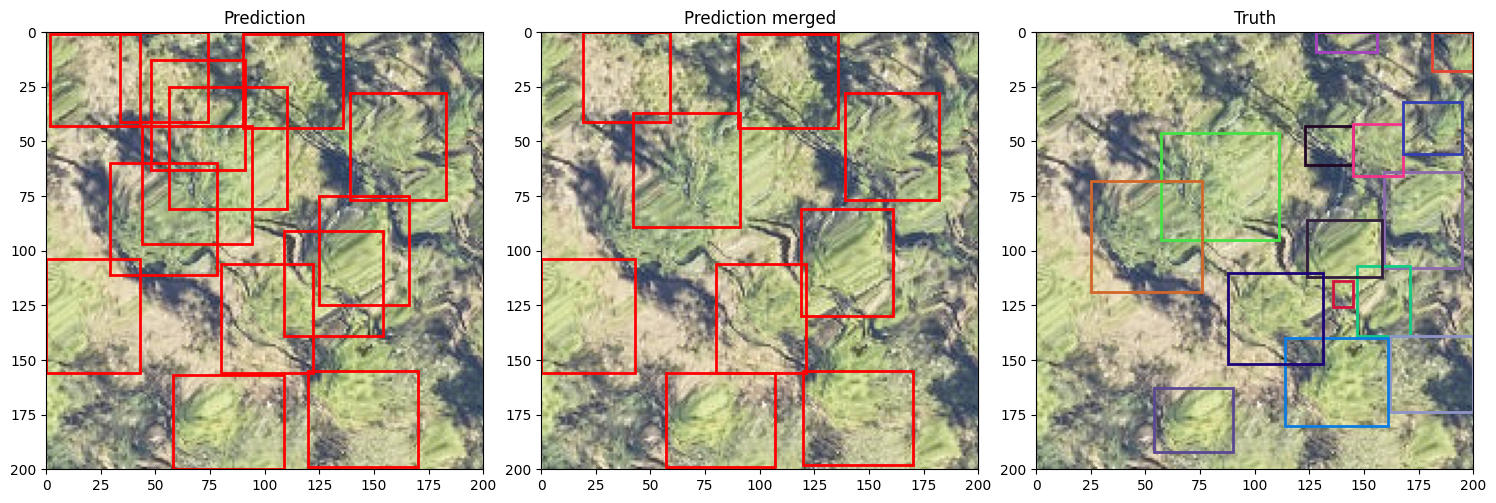

<Figure size 640x480 with 0 Axes>

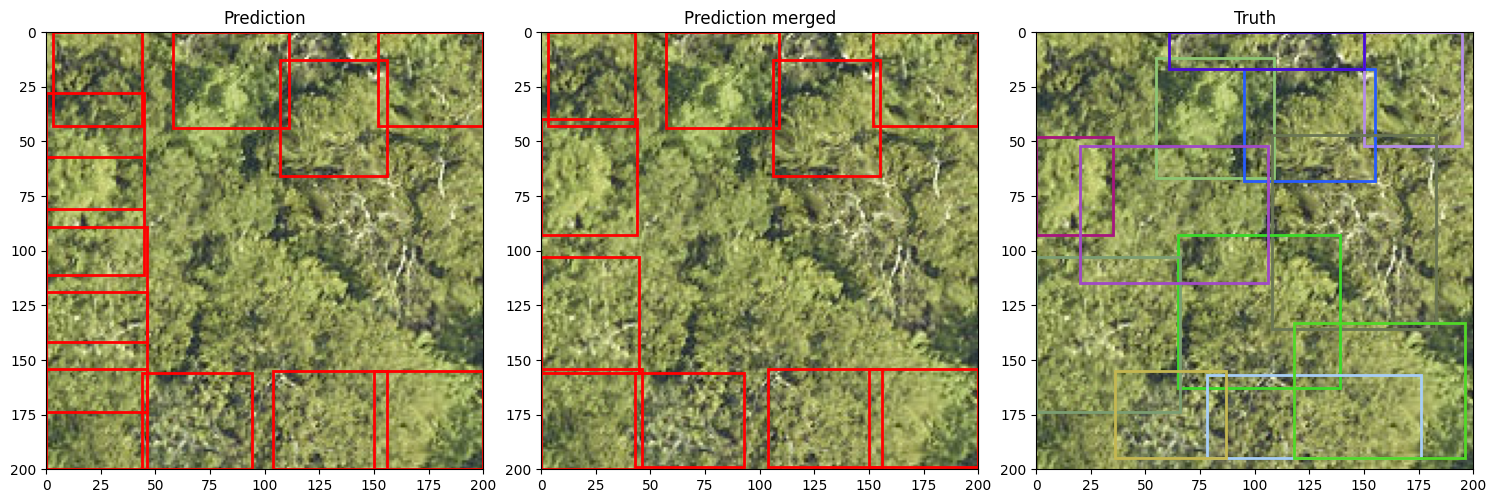

<Figure size 640x480 with 0 Axes>

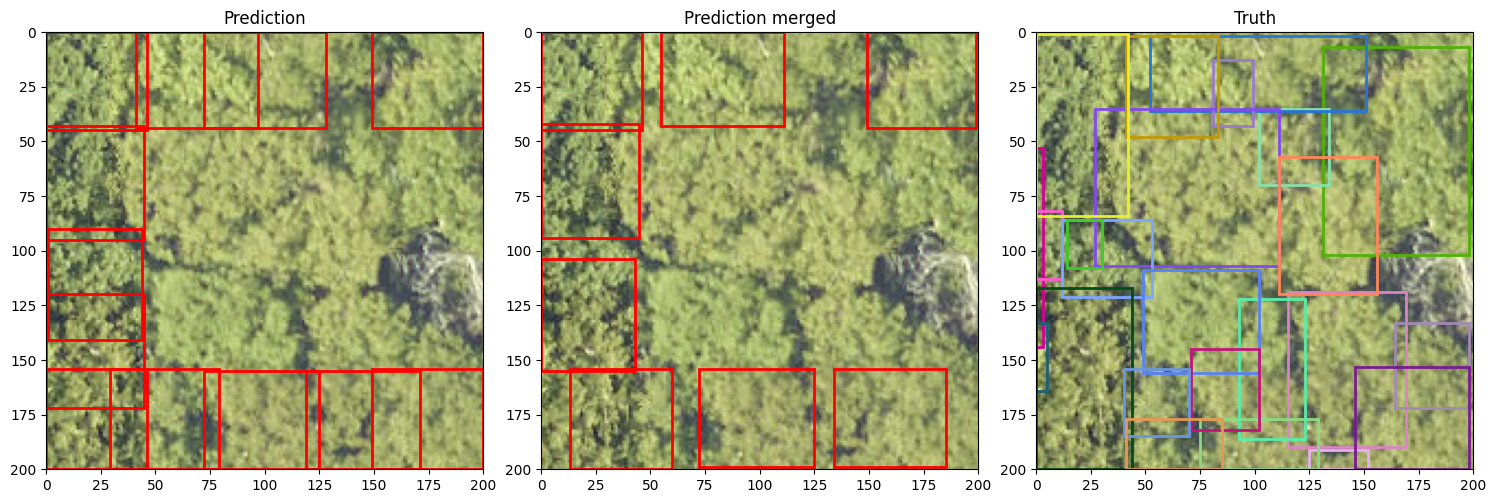

In [ ]:
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from ipywidgets import IntRangeSlider 
import matplotlib.pyplot as plt


df_test = pd.read_csv(os.path.join(dir_,'data/interim/ITC/test_pixel_v3.csv'))
subset_shp = os.path.join(dir_,f'data/interim/ITC/test.shp') # subset shapefile path

@interact(id=widgets.IntSlider(min=0, max=8, step=1, value=6, description='Image #:'))
#@interact(exp=widgets.IntSlider(min=0, max=25, step=1, value=25, description='Exp #:'))
def show_rbg_with_bboxes(id):
    
    
    base_dir = os.path.join(dir_,'data/interim/RemoteSensing')
   
    subset_list = sorted(glob(os.path.join(base_dir, 'test', 'RGB', '*.tif'))) # list of subset files' path
  
    plt.clf()
    f, axarr = plt.subplots(1,3,figsize=(15, 15)) 
   

    f.tight_layout()
   
    f.subplots_adjust(top=1.4)
    
    i = id
    img_path = subset_list[i] 
    
    img_name = os.path.basename(img_path) # get filename
    print(dir_)
    bboxes_path = os.path.join(dir_,f'yolov5/runs/detect/exp26/labels/')+f'{img_name[:-4]}.txt'
    print(bboxes_path)
    bboxes,confs = get_bboxes_from_YOLOv5(bboxes_path)
 
    merged_bboxes_ = merge_bboxes(bboxes_path ,'weighted_boxes_fusion')
    merged_bboxes_ = [convert_xyxy_2_xywh(boxe) for boxe in merged_bboxes_]
    #Prediction
    img = d_images[img_name[:-4]]
    rasterio.plot.show(img, ax=axarr[0])
    axarr[0].set_title('Prediction')
    
    for (class_, bboxe),conf in zip(bboxes,confs):
      if conf< 0.0:
        continue
      rect = patches.Rectangle((bboxe[0], bboxe[1]),bboxe[2], bboxe[3], linewidth=2, edgecolor='r', facecolor='none')
      axarr[0].add_patch(rect)

    # Prediction merged
    rasterio.plot.show(img, ax=axarr[1])
    axarr[1].set_title('Prediction merged')
    
    for bboxe in merged_bboxes_:
      rect = patches.Rectangle((int(bboxe[0]*200), int(bboxe[1]*200)),int(bboxe[2]*200), int(bboxe[3]*200), linewidth=2, edgecolor='r', facecolor='none')
      axarr[1].add_patch(rect)

    #Truth
    rasterio.plot.show(img, ax=axarr[2])
    axarr[2].set_title('Truth')
    bboxes = get_bboxes_from_df(df_test,img_name,'xmin_ymin_w_h')

    for class_, bboxe in bboxes:
      rect = patches.Rectangle((bboxe[0], bboxe[1]),bboxe[2], bboxe[3], linewidth=2, edgecolor=np.random.rand(3,), facecolor='none')
      axarr[2].add_patch(rect)
    
